# Tutorial 6: Image degradation and inverse filtering
Until now we have seen spatial convolutions and frequency filtering as tools to process images. We later saw how some nice properties of the Fourier transform have enabled computed tomography. Then we looked at different aspects of sampling images, witnessed its effects, and learned how to alleviate them. 

Today, our agenda is to understand the formulation of image restoration problems. We will see different kinds of degradations that can happen to an image and learn how to model them. We will also discuss inverse filtering, which is one of the most basic methods to alleviate them.

Agenda:
- White noise
- Salt and pepper noise
- Shot noise
- Focal blur
- Motion blur
- Inverse filtering

In [20]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import fftpack
import scipy.signal
import warnings
warnings.filterwarnings('ignore')

## Noise models

Let's experiment with different noise models.

First we will choose an image as our test subject.

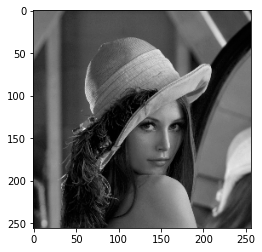

In [21]:
WHITE_LEVEL = 255
SIZE = 256

image = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE) / WHITE_LEVEL
image = cv2.resize(image, (SIZE, SIZE))

plt.imshow(image, cmap='gray')
plt.show()

### White noise

White noise is a zero-mean i.i.d. Gaussian additive noise. It is the most common model for imaging noise.

It is hard to deal with this type of noise even in the frequency domain, since it has equal intensity at all frequencies.

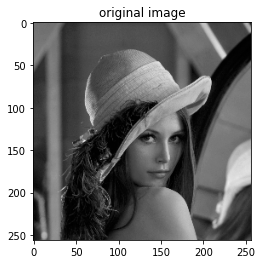

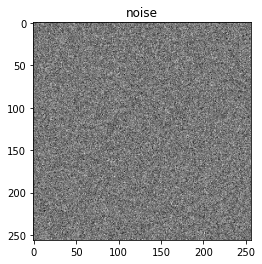

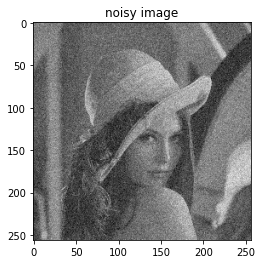

In [22]:
NOISE_STD = 0.1

noise = np.random.normal(scale=NOISE_STD, size=image.shape)
noisy_image = image + noise

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

plt.imshow(noise, cmap='gray')
plt.title('noise')
plt.show()

plt.imshow(noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

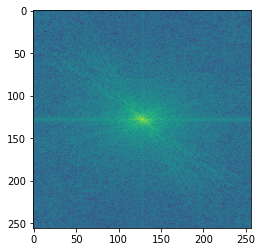

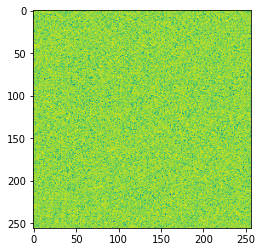

In [23]:
from scipy.fftpack import fft2, fftshift

fourier_lena = fftshift(fft2(image))
plt.imshow(np.log(np.abs(fourier_lena)))
plt.show()

fourier_noise = fftshift(fft2(noise))
plt.imshow(np.log(np.abs(noise)))
plt.show()

### Salt and pepper noise

Salt and pepper noise presents itself as sparsely occurring white and black pixels. It can occur due to the use of faulty instruments.

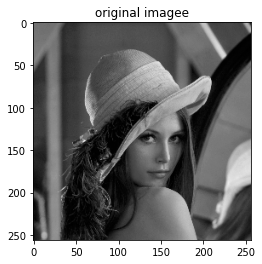

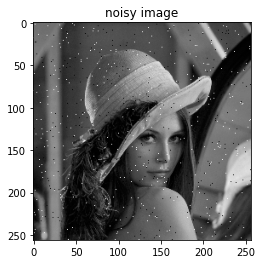

In [24]:
AMOUNT = 0.01   # proportion of pixels are corrupted
SALT_VS_PEPPER = 0.5  # probability of being blank or saturated

noisy_image = image.copy()
number_faulty_pixels = np.ceil(AMOUNT * image.size).astype(int)
indices = np.random.randint(0, high=SIZE, size=(2, number_faulty_pixels))
values = np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels)
noisy_image[tuple(np.split(indices, 2))] = values

plt.imshow(image, cmap='gray')
plt.title('original imagee')
plt.show()

plt.imshow(noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

### Shot noise

Shot noise is any discrete type of noise which can be modeled as a Poisson process. It occures in photon counting in optical devices, due to the particle nature of light. Therefore this type of noise is especially noticeable in low-light conditions, or when the exposure time is low.

It should not be confused with dark noise, which is an additive Poisson noise.

Poisson distributions are parameterized by $\lambda$, which is equal to both the expectation and the variance:

<img src='Poisson-Noise.png' width="360">

Therefore bright pixels will be noiser than dark ones.

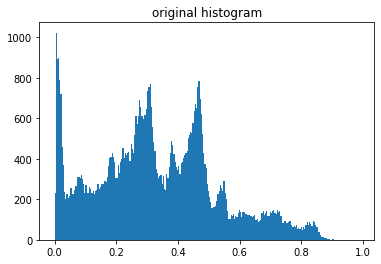

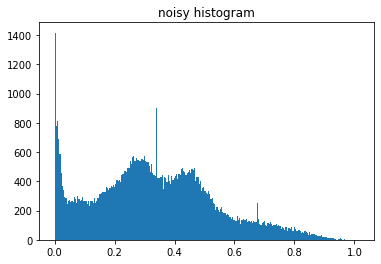

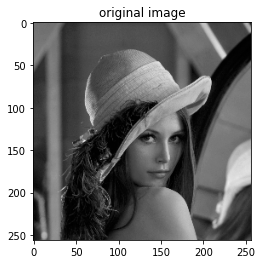

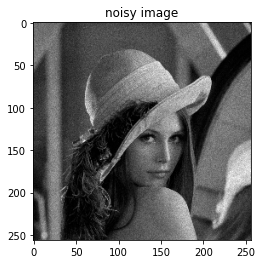

In [26]:
NUM_BINS = 256

lam = image * WHITE_LEVEL
noisy_image = np.random.poisson(lam=lam) / WHITE_LEVEL

plt.hist(image.ravel(), bins=NUM_BINS)
plt.title('original histogram')
plt.show()

plt.hist(noisy_image.ravel(), bins=NUM_BINS)
plt.title('noisy histogram')
plt.show()

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

plt.imshow(noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

## Blur

### Focal blur

The impulse response $h$ of an operator $\mathcal{H}$ obeys
$$
\left(\mathcal{H}f\right)\left(x\right)=\int_{\mathbb{R}^d}h\left(x,x'\right)f\left(x'\right)dx'.
$$

Specifically, an LSI system obeys
$$
\left(\mathcal{H}f\right)\left(x\right)=\int_{\mathbb{R}^d}h\left(x-x'\right)f\left(x'\right)dx'=f\ast h.
$$

We call the impulse response of an imaging system the PSF (point spread function).

Ideally we would like the PSF to be the indicator function.

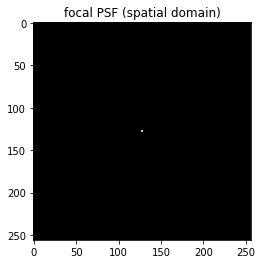

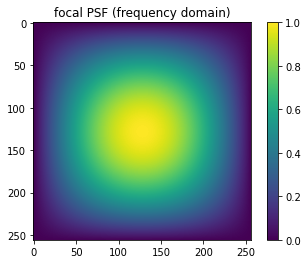

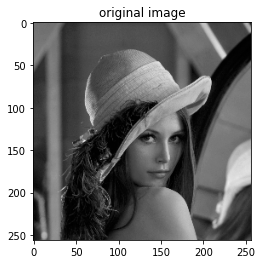

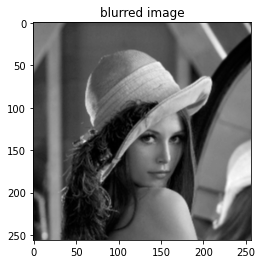

In [30]:
FOCAL_STD = 0.1 # 3  # if focal blur is increased in spatial domain, what happens in the Fourier domain?

def gaussian_kernel(size, std=1):
    edge = size // 2
    ax = np.linspace(-edge, edge, num=size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2 * std **2))
    return kernel / kernel.sum()

psf = gaussian_kernel(SIZE, std=FOCAL_STD)
plt.imshow(psf, cmap='gray')
plt.title('focal PSF (spatial domain)')
plt.show()

psf_dft = fftpack.fftshift(fftpack.fft2(psf))
plt.title('focal PSF (frequency domain)')
plt.imshow(np.abs(psf_dft))
plt.colorbar()
plt.show()

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

blurred_image = scipy.signal.convolve(image, psf, mode='same')
plt.imshow(blurred_image, cmap='gray')
plt.title('blurred image')
plt.show()

In reality, however, due to physical constraints, the focus of the camera lenses is suboptimal.

Try increasing `PSF_STD` and see how it blurs the image, causing the information in the higher frequencies to be lost.

### Motion blur

If the camera moves when the aperture is exposed, the PSF changes, resulting in a motion blur.

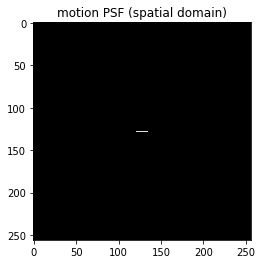

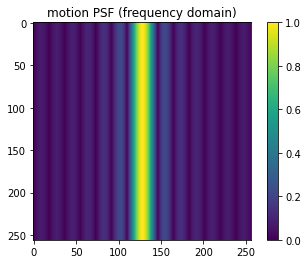

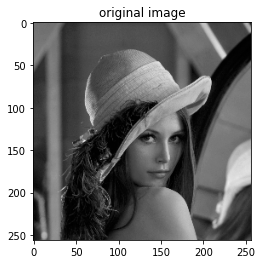

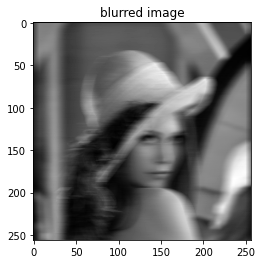

In [31]:
LENGTH = 15

def horizontal_motion_blur(size, length):
    center = size // 2
    shift = length // 2
    kernel = np.zeros((size, size))
    kernel[center:center + 1, center - shift:center + shift] = 1
    return kernel / kernel.sum()

psf = horizontal_motion_blur(SIZE, LENGTH)
plt.imshow(psf, cmap='gray')
plt.title('motion PSF (spatial domain)')
plt.show()

psf_dft = fftpack.fftshift(fftpack.fft2(psf))
plt.title('motion PSF (frequency domain)')
plt.imshow(np.abs(psf_dft))
plt.colorbar()
plt.show()

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

blurred_image = scipy.signal.convolve(image, psf, mode='same')
plt.imshow(blurred_image, cmap='gray')
plt.title('blurred image')
plt.show()

Compared to the focal blur, we can see that the information in some of the higher frequencies is still kept, depending on the motion direction.

## Inverse filtering

Let $f$ be the clean image and $y$ be the blurred version that is obtained by the blur PSF $h$.

If we ignore the noise, we get

$$
y = f \ast h 
$$

Our goal is to recover the clean image $f$ given $y$ and the PSF $h$.

Observing the above equation in the frequency domain yields

$$
Y = FH
$$

Ideally, we can estimate $f$ by

$$
\hat{F} = \frac{Y}{H}
$$

This method is called **inverse filtering**. Let's see how well it performs in practice.

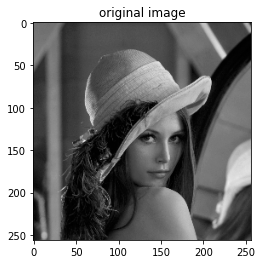

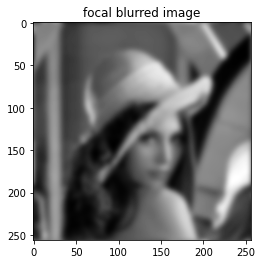

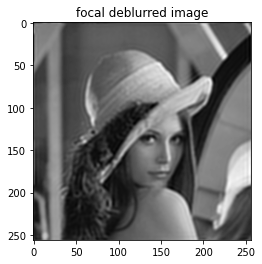

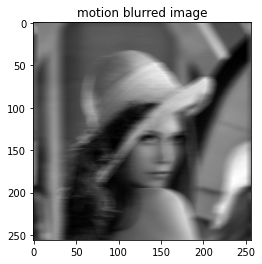

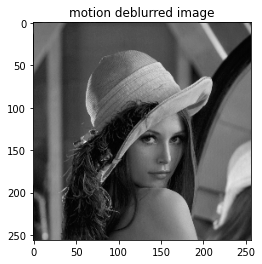

In [34]:
EPSILON = 1e-3
FOCAL_STD = 3
LENGTH = 15

def inverse_filter(image, psf):
    image_dft = fftpack.fft2(image)
    psf_dft = fftpack.fft2(fftpack.ifftshift(psf))
    recovered_dft = image_dft / (psf_dft + EPSILON)
    return np.real(fftpack.ifft2(recovered_dft))

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

focal_blur_psf = gaussian_kernel(SIZE, std=FOCAL_STD)
focal_blurred_image = scipy.signal.convolve2d(image, focal_blur_psf, mode='same', boundary='wrap')
plt.imshow(focal_blurred_image, cmap='gray')
plt.title('focal blurred image')
plt.show()

focal_deblurred_image = inverse_filter(focal_blurred_image, focal_blur_psf)
plt.imshow(focal_deblurred_image, cmap='gray')
plt.title('focal deblurred image')
plt.show()

motion_blur_psf = horizontal_motion_blur(SIZE, LENGTH)
motion_blurred_image = scipy.signal.convolve2d(image, motion_blur_psf, mode='same', boundary='wrap')
plt.imshow(motion_blurred_image, cmap='gray')
plt.title('motion blurred image')
plt.show()

motion_deblurred_image = inverse_filter(motion_blurred_image, motion_blur_psf)
plt.imshow(motion_deblurred_image, cmap='gray')
plt.title('motion deblurred image')
plt.show()

Since the focal blur zeored all of the information in the higher frequencies, our deblurred image contains high frequency artifacts, which are similar to the aliasing artifacts we have seen while sampling. They are mostly visible near edges.

The deblurred image we got for the motion blur case, on the other hand, looks great. That's because not all of the information in the high frequencies was gone, and the inverse filtering method was able to recover it.

Pay attention to the fact that we have set the parameter `boundary='wrap'` for `scipy.signal.convolve2d`. Try changing it. How does it affect the deblurred images?

The reason behind this is the fact that DFT diagonalizes circular convolution operators (or ciruclar matrices, as we have explained in tutorial 2). This property is necessary for the convolution theorem, and therefore the inverse filtering method, to stay valid in the discrete case. Alternatively, we could have implemented the convolution via point-wise multiplication in the frequency domain.